## Демо

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

%matplotlib inline

#device = "cuda:0"

In [ ]:
df_train = pd.read_csv("/content/Data_train.csv")
df_test = pd.read_csv("/content/Data_test.csv")

In [ ]:
df_train.head()

,type,group,education,meal,preparation course,score-1,score-2,score-3
0,wild,group B,some high school,standard,completed,63,67,67
1,domestic,group C,bachelor's degree,standard,none,67,69,75
2,domestic,group C,some college,standard,completed,69,90,88
3,domestic,group B,some high school,standard,none,62,64,66
4,wild,group E,some college,reduced,none,93,90,83


In [ ]:
df_test.head()

,type,group,education,meal,preparation course
0,wild,group D,some college,standard,none
1,wild,group C,master's degree,reduced,completed
2,wild,group B,some college,reduced,completed
3,wild,group A,associate's degree,reduced,none
4,domestic,group B,some college,standard,completed


In [ ]:
df_train.isna().sum()

,0
type,0
group,20
education,0
meal,0
preparation course,0
score-1,0
score-2,0
score-3,0


In [ ]:
df_test["group"].unique(), df_train["group"].unique()

(array(['group D', 'group C', 'group B', 'group A', 'group E', nan],
       dtype=object),
 array(['group B', 'group C', 'group E', 'group D', 'group A', nan],
       dtype=object))

In [ ]:
df_train["group"] = df_train["group"].fillna("group F")
df_test["group"] = df_test["group"].fillna("group F")

In [ ]:
def pass_condition(row):
    return int((row['score-1'] > 50) & (row['score-2'] > 50) & (row['score-3'] > 50))

df_train["pass"] = df_train.apply(pass_condition, axis=1)

In [ ]:
df_train["pass"].value_counts()

,count
pass,
1,555
0,145


In [ ]:
train_wild = df_train[df_train['type']=="wild"]
train_wild["pass"].value_counts()

,count
pass,
1,268
0,75


In [ ]:
268/(75+268)

0.7813411078717201

In [ ]:
train_domestic = df_train[df_train['type']=="domestic"]
train_domestic["pass"].value_counts()

,count
pass,
1,287
0,70


In [ ]:
287/(287+70)

0.803921568627451

In [ ]:
abs(287/(287+70)-268/(75+268))

0.022580460755730947

In [ ]:
df_train[df_train["education"]=="high school"]["pass"].value_counts()

,count
pass,
1,99
0,35


In [ ]:
df_train["preparation course"].unique()

array(['completed', 'none'], dtype=object)

In [ ]:
train_wild[train_wild["preparation course"]=="none"]["pass"].value_counts()

,count
pass,
1,152
0,60


In [ ]:
df_train['score-1'].median()

66.0

In [ ]:
df_train['score-3'].quantile(q=0.25, "lower")-df_train['score-3'].quantile(q=0.75)

np.float64(-21.0)

In [ ]:
df_train_encoded = pd.get_dummies(df_train, columns=df_train.dtypes[df_train.dtypes==object].keys(), drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=df_test.dtypes[df_test.dtypes==object].keys(), drop_first=True)

In [ ]:
len(df_train_encoded.columns), len(df_test_encoded)

(17, 300)

In [ ]:
df_train_encoded = df_train_encoded.astype(int)

In [ ]:
df_test_encoded = df_test_encoded.astype(int)

In [ ]:
y = df_train["pass"]
X = df_train_encoded.astype(int).drop(columns=['pass'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score

In [ ]:
clf = DecisionTreeClassifier(max_depth=5, criterion='entropy').fit(X, y)

In [ ]:
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(max_depth=5, criterion='entropy')
scores = cross_val_score(clf, X, y, cv=3, scoring='roc_auc')
print("%0.1f accuracy with a standard deviation of %0.1f" % (scores.mean(), scores.std()))

1.0 accuracy with a standard deviation of 0.0


In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(2,21)}
dt = DecisionTreeClassifier(criterion='entropy')
clf = GridSearchCV(dt, parameters, cv=3, scoring='roc_auc')
clf.fit(X, y)

best_max_depth = clf.best_params_['max_depth']
best_max_depth

4

In [ ]:
def get_cat_bio(row):
    return f"({row['type']}, {row['type']})"

df_train["cat_bio"] = df_train.apply(get_cat_bio, axis=1)
df_test["cat_bio"] = df_test.apply(get_cat_bio, axis=1)

In [ ]:
df_train

,type,group,education,meal,preparation course,score-1,score-2,score-3,pass,cat_bio
0,wild,group B,some high school,standard,completed,63,67,67,1,"(wild, wild)"
1,domestic,group C,bachelor's degree,standard,none,67,69,75,1,"(domestic, domestic)"
2,domestic,group C,some college,standard,completed,69,90,88,1,"(domestic, domestic)"
3,domestic,group B,some high school,standard,none,62,64,66,1,"(domestic, domestic)"
4,wild,group E,some college,reduced,none,93,90,83,1,"(wild, wild)"
...,...,...,...,...,...,...,...,...,...,...
695,wild,group C,some high school,standard,completed,67,73,68,1,"(wild, wild)"
696,domestic,group B,high school,reduced,none,8,24,23,0,"(domestic, domestic)"
697,wild,group E,some college,standard,completed,85,75,68,1,"(wild, wild)"
698,wild,group E,associate's degree,standard,none,53,45,40,0,"(wild, wild)"


In [ ]:
X = df_train[["cat_bio", "education", "meal", "preparation course"]]
X_test = df_test[["cat_bio", "education", "meal", "preparation course"]]

In [ ]:
X = pd.get_dummies(X, columns=X.dtypes[X.dtypes==object].keys(), drop_first=True)
X = X.astype(int)

X_test = pd.get_dummies(X_test, columns=X_test.dtypes[X_test.dtypes==object].keys(), drop_first=True)
X_test = X_test.astype(int)

In [ ]:
clf = DecisionTreeClassifier(max_depth=5, criterion='entropy').fit(X, y)

In [ ]:
probs = clf.predict(X_test)

# Вычисляем значение ROC-AUC
roc_auc = round(roc_auc_score(y_test, probs), 2)
print(f"Roc-AUC score: {roc_auc}")

NameError: name 'y_test' is not defined

# Вариант 1

In [184]:
df_train = pd.read_csv("/content/TrainData.csv")
df_test = pd.read_csv("/content/TestData.csv")

In [ ]:
df_train.isnull().sum()

,0
0,0
1,5
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [ ]:
df_train['1'].mean()

np.float64(31.28322514908239)

In [ ]:
df_train['1'] = df_train['1'].fillna(df_train['1'].mean())

In [ ]:
df_train['13']

,13
0,135.0
1,1001.0
2,1.0
3,16.0
4,68.0
...,...
508,247.0
509,501.0
510,1.0
511,1.0


In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train.target.value_counts()

,count
target,
Not churn,276
Churn,232
Chorn,1
Not chorn,1


In [ ]:
df_train.target = df_train.target.replace('Chorn', "Churn").replace('Not chorn', "Not churn")

In [ ]:
df_train.target = df_train.target.replace('Not churn',0).replace('Churn',1)

<ipython-input-159-652e16f9d26d>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train.target = df_train.target.replace('Not churn',0).replace('Churn',1)


In [ ]:
X_train = df_train.drop("target", axis=1)

In [ ]:
X_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13'],
      dtype='object')

In [ ]:
s = 0
for i in X_train.columns:
    if len(X_train[f"{i}"].unique()) < 5:
        s +=1
s

6

In [ ]:
df_train[["7", "target"]]

,7,target
0,A,1
1,B,0
2,A,1
3,A,1
4,B,0
...,...,...
508,B,0
509,A,1
510,A,1
511,A,1


In [ ]:
(df_train["2"]>df_train["2"].mean()) & (df_train["13"]<df_train["13"].median())

,0
0,False
1,False
2,True
3,False
4,False
...,...
508,False
509,False
510,True
511,False


In [ ]:
tmp = df_train[(df_train["2"]>df_train["2"].mean()) & (df_train["13"]<df_train["13"].median())]

In [ ]:
tmp["target"].mean()

np.float64(0.5056179775280899)

In [ ]:
45/(45+44)

0.5056179775280899

In [ ]:
tmp.mean()

np.float64(0.5056179775280899)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train["7"] = le.fit_transform(df_train["7"])

In [ ]:
df_train.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,target
0,1.000000,0.060355,-0.025785,-0.080933,-0.037662,0.057068,0.114514,-0.014552,-0.100440,0.015802,0.021650,-0.069946,0.049324,-0.024011,0.002205
1,0.060355,1.000000,0.208128,0.117217,-0.110280,0.049470,0.365135,-0.199069,0.093323,0.164922,0.039525,0.042374,-0.103528,0.080626,0.134423
2,-0.025785,0.208128,1.000000,0.084453,0.067059,0.118559,0.307772,-0.281101,0.214150,0.307833,-0.012715,0.075142,-0.228701,0.025319,0.235356
3,-0.080933,0.117217,0.084453,1.000000,0.116146,0.075686,0.098971,-0.162529,0.186963,0.114268,-0.022807,-0.010870,-0.026698,0.068965,0.195196
4,-0.037662,-0.110280,0.067059,0.116146,1.000000,0.397585,0.160295,-0.299730,0.210317,0.131898,0.038853,0.044263,0.073154,0.113586,0.361948
5,0.057068,0.049470,0.118559,0.075686,0.397585,1.000000,0.241687,-0.241128,0.057506,0.093464,0.114035,0.039108,0.033308,0.033435,0.236240
6,0.114514,0.365135,0.307772,0.098971,0.160295,0.241687,1.000000,-0.350936,0.252173,0.357088,0.153543,-0.000168,-0.111287,0.098151,0.338649
7,-0.014552,-0.199069,-0.281101,-0.162529,-0.299730,-0.241128,-0.350936,1.000000,-0.433168,-0.368253,-0.127197,-0.027685,0.058814,-0.165116,-0.712986
8,-0.100440,0.093323,0.214150,0.186963,0.210317,0.057506,0.252173,-0.433168,1.000000,0.550849,0.045526,0.203288,-0.041990,0.141921,0.444122
9,0.015802,0.164922,0.307833,0.114268,0.131898,0.093464,0.357088,-0.368253,0.550849,1.000000,0.020953,0.111981,-0.135562,0.104265,0.387345


In [ ]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,32.08,4.000,1,13,4,1.500,B,0,0,1,2,120,1
1,0,23.50,1.500,2,9,4,0.875,B,0,0,1,2,160,1
2,0,33.25,2.500,1,8,4,2.500,B,0,0,1,2,0,3
3,1,74.83,19.000,1,1,1,0.040,B,1,2,0,2,0,352
4,1,20.17,5.625,2,9,4,1.710,A,0,0,0,1,120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,1,32.67,5.500,2,11,8,5.500,A,1,12,1,2,408,1001
169,1,65.42,11.000,2,10,9,20.000,A,1,7,1,2,22,1
170,0,27.33,1.665,2,1,1,0.000,B,0,0,0,2,340,2
171,1,24.83,2.750,2,8,4,2.250,A,1,6,0,2,184,601


In [185]:
y = df_train["target"]
X_train = df_train.drop("target", axis=1)

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(random_state = 42,penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None).fit(X_train, y)
scores = cross_val_score(clf, X_train, y, cv=3, scoring='f1')
scores.mean()

ValueError: could not convert string to float: 'A'

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(random_state = 42,penalty='l2', dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, class_weight=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None), parameters, scoring="f1_macro", cv=3)
clf.fit(X_train, y)

clf.best_params_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

{'C': 0.01}

In [ ]:
X_train["NEW"]=X_train["7"]*X_train["11"]

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(random_state=42,penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None), parameters, scoring="f1_macro", cv=3)
clf.fit(X_train, y)

clf.best_params_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

{'C': 0.01}

In [ ]:
clf.best_score_

np.float64(0.8623970693262546)

In [ ]:
df_test["7"] = le.fit_transform(df_test["7"])
df_test["NEW"]=df_test["7"]*df_test["11"]

In [ ]:
result = clf.predict(df_test)

In [ ]:
from lightgbm import LGBMRegressor


parameters = {
    'max_depth' : [4, 6, 8],
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators' : [100, 150, 200],
    'num_leaves': [20, 50, 100],
    'reg_alpha': [0.0, 0.1, 0.5]
}

lgbmr = LGBMRegressor()
grid_search = GridSearchCV(estimator=lgbmr, param_grid=parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 510, number of used features: 15
[LightGBM] [Info] Start training from score 0.456863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 150, 200],
                         'num_leaves': [20, 50, 100],
                         'reg_alpha': [0.0, 0.1, 0.5]})

In [ ]:
best_lgbmr = LGBMRegressor(**grid_search.best_params_)
best_lgbmr.fit(X_train, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 510, number of used features: 15
[LightGBM] [Info] Start training from score 0.456863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMRegressor(learning_rate=0.05, max_depth=4, num_leaves=20, reg_alpha=0.1)

In [ ]:
pred_y_lgbmr = best_lgbmr.predict(df_test)

In [ ]:
test_preds = [1 if pred > 0.5 else 0 for pred in pred_y_lgbmr]

In [ ]:
pd.DataFrame(test_preds).to_csv('result1.csv', index = False)

# Демо 2

eigenvalues [2. 3.]
eigenvector [ 0.89442719 -0.4472136 ]


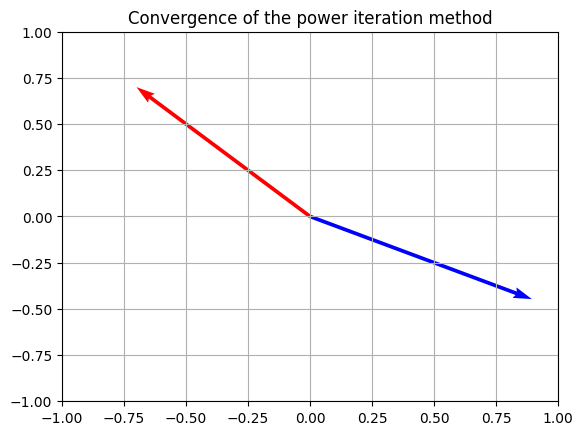

lamda =  4.499999999999999
X =  [-0.7  0.7]


In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from numpy import linalg as LA

# given matrix
A = np.array([[-1, -6], [2, 6]])

eigenvalues, eigenvectors = LA.eig(A)
# an eigenvector corresponding to the max eigenvalue
eigenvector = -eigenvectors[:,0]

print("eigenvalues", eigenvalues)
print("eigenvector",eigenvector)

k = 10
X_origin = [0, 0]
Y_origin = [0, 0]

# Starting vector
#X = np.random.rand(A.shape[0])
# initial guess vector
X = np.array([-0.7, 0.7])

fig, ax = plt.subplots()
plt.title("Convergence of the power iteration method")
plt.grid()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
U = [eigenvector[0], X[0]]
V = [eigenvector[1], X[1]]

q = ax.quiver(X_origin, Y_origin, U, V, color=['b', 'r'], angles='xy', scale_units='xy', scale=1)

def animate(i):
    # Power it
    global X
    if i:
        X = np.matmul(A, X)
        # Normalize it
        X = X / np.linalg.norm(X, ord=2)

    U = [eigenvector[0], X[0]]
    V = [eigenvector[1], X[1]]
    q.set_UVC(U, V)

ani = FuncAnimation(fig, animate, frames=k, repeat=False, interval=1000)

plt.show()

l = np.dot(np.matmul(A, X), X) / np.dot(X, X)

print("lamda = ", l)
print("X = ", X)

# Вариант 2

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

In [ ]:
df_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1057,1,2.7,0,3,1,41,0.1,97,4,...,397,891,2033,16,9,2,1,Yes,0,1
1,1619,1,1.9,0,2,1,21,0.4,138,1,...,46,562,1641,7,2,13,1,No,0,1
2,1028,1,2.8,0,1,1,30,0.1,193,1,...,1801,1923,1424,18,4,13,1,No,1,1
3,1994,1,0.8,1,2,1,7,0.6,88,8,...,667,711,454,11,8,6,1,Yes,0,0
4,1603,1,0.5,1,1,1,17,0.5,114,2,...,430,1207,1637,17,3,11,1,No,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1742,1,1.6,0,3,0,49,0.8,100,1,...,1134,1469,1947,5,4,6,1,No,1,2
1496,1936,0,1.3,0,2,0,44,0.1,139,3,...,570,1021,1400,17,7,3,0,No,1,1
1497,1567,0,0.5,1,3,0,22,0.5,119,6,...,545,1621,2312,9,1,18,1,No,0,2
1498,1456,0,1.6,1,9,1,39,0.1,80,8,...,815,1666,3998,6,3,13,1,Yes,0,3


In [ ]:
df_train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,wifi,price_range
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,1228.148000,0.496000,1.529467,0.512000,4.164000,0.517333,32.426667,0.49540,139.913333,4.486667,9.704667,642.044667,1250.533333,2130.934667,12.255333,5.788667,11.014000,0.762000,0.510667,1.500000
std,439.785748,0.500151,0.811400,0.500023,4.291237,0.499866,18.145048,0.28907,35.425845,2.298117,6.059972,441.994736,432.460692,1085.674395,4.216554,4.336420,5.473126,0.426001,0.500053,1.117213
min,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.10000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,840.000000,0.000000,0.700000,0.000000,0.750000,0.000000,16.000000,0.20000,108.000000,2.000000,4.000000,277.750000,874.000000,1213.750000,9.000000,2.000000,6.000000,1.000000,0.000000,1.000000
50%,1204.000000,0.000000,1.500000,1.000000,3.000000,1.000000,32.000000,0.50000,140.000000,4.000000,10.000000,559.000000,1239.500000,2167.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.500000
75%,1606.250000,1.000000,2.200000,1.000000,7.000000,1.000000,48.000000,0.70000,170.000000,7.000000,15.000000,942.750000,1626.750000,3088.750000,16.000000,9.000000,16.000000,1.000000,1.000000,2.000000
max,1998.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.00000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,3.000000


In [ ]:
df_train["is_internet"] = ~((df_train["wifi"] == 0) & (df_train["three_g"] == 0) &  (df_train["four_g"] == 0))
df_train["is_internet"] = df_train["is_internet"].astype(int)

df_test["is_internet"] = ~((df_train["wifi"] == 0) & (df_train["three_g"] == 0) &  (df_train["four_g"] == 0))
df_test["is_internet"] = df_test["is_internet"].astype(int)

df_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,is_internet
0,1057,1,2.7,0,3,1,41,0.1,97,4,...,891,2033,16,9,2,1,Yes,0,1,1
1,1619,1,1.9,0,2,1,21,0.4,138,1,...,562,1641,7,2,13,1,No,0,1,1
2,1028,1,2.8,0,1,1,30,0.1,193,1,...,1923,1424,18,4,13,1,No,1,1,1
3,1994,1,0.8,1,2,1,7,0.6,88,8,...,711,454,11,8,6,1,Yes,0,0,1
4,1603,1,0.5,1,1,1,17,0.5,114,2,...,1207,1637,17,3,11,1,No,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1742,1,1.6,0,3,0,49,0.8,100,1,...,1469,1947,5,4,6,1,No,1,2,1
1496,1936,0,1.3,0,2,0,44,0.1,139,3,...,1021,1400,17,7,3,0,No,1,1,1
1497,1567,0,0.5,1,3,0,22,0.5,119,6,...,1621,2312,9,1,18,1,No,0,2,1
1498,1456,0,1.6,1,9,1,39,0.1,80,8,...,1666,3998,6,3,13,1,Yes,0,3,1


In [ ]:
df_train["is_internet"].value_counts()

,count
is_internet,
1,1323
0,177


In [ ]:
177/(177+1323)

0.118

In [ ]:
1 - df_train["is_internet"].mean()

np.float64(0.118)

In [ ]:
df_train.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range', 'is_internet'],
      dtype='object')

In [ ]:
df_train[['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
      'wifi', 'price_range', 'is_internet']].corr()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,wifi,price_range,is_internet
battery_power,1.000000,-0.013861,-0.009412,-0.044354,0.051456,0.017616,-0.010526,0.011010,-0.009539,-0.031947,...,0.009640,-0.002495,-0.006910,-0.045465,-0.037786,0.050955,-0.000852,-0.010822,0.200020,0.028335
blue,-0.013861,1.000000,0.007524,0.048207,0.019266,0.010951,0.035693,0.006102,-0.023213,0.060895,...,-0.019381,-0.041757,0.041575,0.001275,-0.003620,0.007697,-0.037347,-0.029170,0.023878,-0.062856
clock_speed,-0.009412,0.007524,1.000000,0.005869,0.020472,-0.051920,0.012390,-0.032557,-0.002378,-0.012418,...,-0.006222,0.003311,0.025047,-0.043245,-0.011387,-0.036611,-0.045124,-0.011627,0.012216,-0.046073
dual_sim,-0.044354,0.048207,0.005869,1.000000,-0.034806,-0.030192,0.007303,-0.026156,0.000473,-0.027727,...,-0.017463,0.003423,0.042779,-0.027242,-0.020828,-0.035529,-0.025731,-0.003180,0.020301,-0.055299
fc,0.051456,0.019266,0.020472,-0.034806,1.000000,-0.024029,-0.020827,-0.011761,0.024111,-0.039284,...,0.017027,0.017979,-0.016632,-0.005818,-0.008102,-0.020804,-0.022061,0.013485,-0.000835,-0.029372
four_g,0.017616,0.010951,-0.051920,-0.030192,-0.024029,1.000000,0.013232,0.004015,-0.030204,-0.044515,...,-0.025782,-0.001956,0.004071,0.017681,0.032621,-0.050930,0.578592,-0.011416,0.016724,0.378676
int_memory,-0.010526,0.035693,0.012390,0.007303,-0.020827,0.013232,1.000000,-0.000974,-0.046147,-0.031156,...,0.022762,0.012177,0.026048,0.032467,0.024835,0.006167,-0.007481,0.013762,0.050547,0.009287
m_dep,0.011010,0.006102,-0.032557,-0.026156,-0.011761,0.004015,-0.000974,1.000000,0.031882,0.016628,...,0.023550,0.034866,-0.006934,-0.020053,0.004652,0.025214,-0.002396,-0.025736,-0.000310,0.007765
mobile_wt,-0.009539,-0.023213,-0.002378,0.000473,0.024111,-0.030204,-0.046147,0.031882,1.000000,-0.023859,...,0.015621,-0.014540,-0.004059,-0.046160,-0.019170,0.008656,-0.005081,0.024718,-0.031402,0.020579
n_cores,-0.031947,0.060895,-0.012418,-0.027727,-0.039284,-0.044515,-0.031156,0.016628,-0.023859,1.000000,...,0.004306,0.035210,-0.001078,-0.004571,0.024385,0.017226,-0.028115,-0.024258,-0.005716,-0.027759


In [ ]:
df3b = df_train[df_train["price_range"]==2]
1 - df3b.blue.mean()

np.float64(0.523936170212766)

In [ ]:
df3c = df_train[df_train["talk_time"] < 10]
df3c["dual_sim"].value_counts()

,count
dual_sim,
1,339
0,291


In [ ]:
339-291

48

In [ ]:
X = df_train.drop("price_range", axis=1)
y = df_train["price_range"]

In [ ]:
X["touch_screen"].value_counts()

,count
touch_screen,
Yes,759
No,739
-,2


In [ ]:
X["touch_screen"] = X["touch_screen"].replace("-", "Yes")

In [ ]:
X["touch_screen"].value_counts()

,count
touch_screen,
Yes,761
No,739


In [ ]:
X = pd.get_dummies(X, columns=X.dtypes[X.dtypes==object].keys(), drop_first=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X["touch_screen"] = le.fit_transform(X["touch_screen"])
X

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,is_internet
0,1057,1,2.7,0,3,1,41,0.1,97,4,...,397,891,2033,16,9,2,1,1,0,1
1,1619,1,1.9,0,2,1,21,0.4,138,1,...,46,562,1641,7,2,13,1,0,0,1
2,1028,1,2.8,0,1,1,30,0.1,193,1,...,1801,1923,1424,18,4,13,1,0,1,1
3,1994,1,0.8,1,2,1,7,0.6,88,8,...,667,711,454,11,8,6,1,1,0,1
4,1603,1,0.5,1,1,1,17,0.5,114,2,...,430,1207,1637,17,3,11,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1742,1,1.6,0,3,0,49,0.8,100,1,...,1134,1469,1947,5,4,6,1,0,1,1
1496,1936,0,1.3,0,2,0,44,0.1,139,3,...,570,1021,1400,17,7,3,0,0,1,1
1497,1567,0,0.5,1,3,0,22,0.5,119,6,...,545,1621,2312,9,1,18,1,0,0,1
1498,1456,0,1.6,1,9,1,39,0.1,80,8,...,815,1666,3998,6,3,13,1,1,0,1


In [ ]:
df_test = pd.get_dummies(df_test, columns=df_test.dtypes[df_test.dtypes==object].keys(), drop_first=True)

In [ ]:
df_test["touch_screen"] = le.fit_transform(df_test["touch_screen"])
df_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,is_internet
0,1379,0,0.5,1,1,0,19,0.3,134,8,...,387,671,3912,11,2,19,0,2,1,1
1,587,1,2.5,0,16,1,51,0.6,111,1,...,244,1361,2746,10,4,7,1,1,1,1
2,1866,0,1.4,0,0,0,30,0.5,182,3,...,108,1781,3834,16,11,8,0,1,0,1
3,1242,0,1.1,1,0,0,10,0.6,165,2,...,459,1225,1050,11,1,4,1,1,1,1
4,726,0,2.9,0,0,0,43,0.1,101,8,...,666,760,1446,17,2,8,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1277,1,0.5,1,0,1,35,0.4,142,6,...,309,1460,3559,18,17,6,1,2,0,1
496,1992,1,1.6,0,5,1,57,1.0,100,2,...,1552,1596,606,9,3,4,1,2,1,1
497,1944,0,0.6,1,9,1,59,0.2,132,7,...,634,1079,769,19,13,3,1,1,1,1
498,674,1,2.8,1,0,1,8,0.2,93,3,...,750,772,589,18,6,4,1,2,0,0


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=3, scoring="f1_weighted")
scores.mean()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

np.float64(0.6341472847191132)

In [ ]:
clf = LogisticRegression(random_state=42, penalty='l2', dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, class_weight=None,  solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {"C": [0.001, 0.01, 0.1, 10, 100]}

grid = GridSearchCV(estimator=clf, param_grid=params, cv=3, scoring="f1_weighted")

grid.fit(X, y)

print(grid.best_score_)
print(grid.best_estimator_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

0.6259772280404028
LogisticRegression(C=0.01, multi_class='auto', random_state=42)


In [ ]:
X["ram_resolution"] = X.ram * (X.px_height + X.px_width)
df_test["ram_resolution"] = df_test.ram * (df_test.px_height + df_test.px_width)

In [ ]:
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

In [ ]:
params = {"C": [0.001, 0.01, 0.1, 10, 100]}

grid = GridSearchCV(estimator=clf, param_grid=params, cv=3, scoring="f1_weighted")

grid.fit(X, y)

print(grid.best_score_)
print(grid.best_estimator_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

0.687129255243672
LogisticRegression(C=10, multi_class='auto')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of

In [ ]:
df_test.shape, X.shape

((500, 21), (1500, 21))

In [ ]:
from lightgbm import LGBMClassifier


parameters = {
    'max_depth' : [4, 6, 8, 12, 15],
    'learning_rate' : [0.001, 0.01, 0.05, 0.1],
    'n_estimators' : [100, 150, 200, 250],
    'num_leaves': [15, 20, 25, 30, 50, 100],
    'reg_alpha': [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
}

lgbmr = LGBMClassifier()
grid_search = GridSearchCV(estimator=lgbmr, param_grid=parameters, cv=3, n_jobs=-1)
grid_search.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 21
[LightGBM] [Info] Start training from score -1.388965
[LightGBM] [Info] Start training from score -1.383631
[LightGBM] [Info] Start training from score -1.383631
[LightGBM] [Info] Start training from score -1.388965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8, 12, 15],
                         'n_estimators': [100, 150, 200, 250],
                         'num_leaves': [15, 20, 25, 30, 50, 100],
                         'reg_alpha': [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]})

In [ ]:
best_lgbmr = LGBMClassifier(**grid_search.best_params_)
best_lgbmr.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 21
[LightGBM] [Info] Start training from score -1.388965
[LightGBM] [Info] Start training from score -1.383631
[LightGBM] [Info] Start training from score -1.383631
[LightGBM] [Info] Start training from score -1.388965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(max_depth=4, num_leaves=20)

In [ ]:
pred_y_lgbmr = best_lgbmr.predict(df_test)
test_preds = [abs(round(pred)) for pred in pred_y_lgbmr]
pd.DataFrame(test_preds).to_csv('мфк3.csv', index = False)

In [ ]:
X

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,is_internet
0,1057,1,2.7,0,3,1,41,0.1,97,4,...,397,891,2033,16,9,2,1,1,0,1
1,1619,1,1.9,0,2,1,21,0.4,138,1,...,46,562,1641,7,2,13,1,0,0,1
2,1028,1,2.8,0,1,1,30,0.1,193,1,...,1801,1923,1424,18,4,13,1,0,1,1
3,1994,1,0.8,1,2,1,7,0.6,88,8,...,667,711,454,11,8,6,1,1,0,1
4,1603,1,0.5,1,1,1,17,0.5,114,2,...,430,1207,1637,17,3,11,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1742,1,1.6,0,3,0,49,0.8,100,1,...,1134,1469,1947,5,4,6,1,0,1,1
1496,1936,0,1.3,0,2,0,44,0.1,139,3,...,570,1021,1400,17,7,3,0,0,1,1
1497,1567,0,0.5,1,3,0,22,0.5,119,6,...,545,1621,2312,9,1,18,1,0,0,1
1498,1456,0,1.6,1,9,1,39,0.1,80,8,...,815,1666,3998,6,3,13,1,1,0,1


In [ ]:
y

,price_range
0,1
1,1
2,1
3,0
4,1
...,...
1495,2
1496,1
1497,2
1498,3


# Новый раздел